In [3]:
import pandas as pd
from h3 import h3
import glob
import numpy as np
from pandas import merge
import json
#import geopandas as gpd
import matplotlib.pyplot as plt
#from shapely.geometry import shape
from datetime import datetime, timedelta
import seaborn as sns

In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# Datei einlesen
supply_at_midnight = pd.read_csv('sharenow_supply_data_6mo.csv')

# Config
HEX_RES = 7  # Hexagon Auflösung (siehe uber h3 library)
MIN_CHARGE_LEVEL = 50 # Wenn SoC unter 50% => Auto muss geladen werden

# 1. Wir bauen ein Dataframe, um alle möglichen Hexagon und Datum Kombinationen zu ermitteln. 
all_hexagons = pd.DataFrame(supply_at_midnight["hex_end_{}".format(HEX_RES)].unique(), columns=["hex_end_{}".format(HEX_RES)])
all_dates = pd.DataFrame(supply_at_midnight["date_start"].unique(), columns=["date_start"])

all_hexagons["key"] = 1
all_dates["key"] = 1

template = pd.merge(all_hexagons, all_dates, on=["key"])

template.drop(columns={"key"}, inplace=True)

# 2. In jedem Hexagon für jeden Tag ermitteln wir die Anzahl der Fahrzeuge, die gelanden werden müssen zum Stichzeitpunkt (00.00h)
low_charge_vehicles = supply_at_midnight[supply_at_midnight["fuel_end"]<MIN_CHARGE_LEVEL].groupby(["date_start", "hex_end_{}".format(HEX_RES)])["id"].count().reset_index()

# 3. Wir verschmelzen das Template Data Frame mit den tatsächlichen zu ladenden Fahrzeugen pro Hexagon x Datum
result = pd.merge(template, low_charge_vehicles, on = ["hex_end_7", "date_start"], how="left")

# Hexagon Datum Kombinationen, wo es keine Fahrzeuge gibt, die man laden muss, setzen wir auf 0.
# Hätten wir dieses "template" Dataframe nicht, könnten wir die "0" Fälle nicht ermitteln.
result.fillna(0, inplace=True)

# Spaltenname aussagekräftiger machen
result = result.rename(columns={"id":"number_of_low_soc_vehicle"})


# Ab hier Szenarien bestimmen...

FileNotFoundError: [Errno 2] File sharenow_supply_data_6mo.csv does not exist: 'sharenow_supply_data_6mo.csv'

# 2 Calculate Distribution

In [4]:
# We estimate a Multinomial Distribution
# Calculate Fleet Size per day (n_{k})
fleet_sizes_per_day = result.groupby(["date_start"]).agg({"number_of_low_soc_vehicle":"sum"}).reset_index()
fleet_sizes_per_day = fleet_sizes_per_day.rename(columns={"number_of_low_soc_vehicle":"total_number_of_low_soc_vehicle"})

# Sum_k^K n_{k} 
fleet_size_overall = fleet_sizes_per_day[["total_number_of_low_soc_vehicle"]].sum(axis=0)["total_number_of_low_soc_vehicle"]


## 2.1 Supply Generation 

In [5]:
# p_i for low battery vehicles for multinomial distribution
low_soc_vehicles_coefficients = (result.groupby(["hex_end_{}".format(HEX_RES)]).agg({"number_of_low_soc_vehicle":"sum"})/fleet_size_overall).reset_index()
low_soc_vehicles_coefficients.rename(columns={"number_of_low_soc_vehicle":"prob"}, inplace=True)

# Sort Values
low_soc_vehicles_coefficients = low_soc_vehicles_coefficients.sort_values(by=["hex_end_{}".format(HEX_RES)])

# Convert Probabilities to Numpy Array
low_soc_vehicles_prob_array = low_soc_vehicles_coefficients["prob"].to_numpy()


## 2.2. Sample Scenarios

In [6]:
# Example 
low_soc_vehicle_sample = np.random.multinomial(1000, low_soc_vehicles_prob_array) # No of vehicles to be charged

In [7]:
NO_HEXAGONS = low_soc_vehicle_sample.shape[0]

In [8]:
NO_SCENARIOS = 1000

scenarios = np.empty(shape=[NO_SCENARIOS, NO_HEXAGONS])

In [9]:
# Generate the number of vehicles to be charged
# MLE for poisson distribution 
# MLE Estimator = 1/n * Sum D_t (Di demand at day t, n = 145 Days) (average demand per day)
poisson_mle_vehicles = fleet_sizes_per_day["total_number_of_low_soc_vehicle"].mean()

NO_OF_VEHICLES_TO_BE_CHARGED = np.random.poisson(poisson_mle_vehicles, NO_SCENARIOS)

In [10]:
for i in range(0, NO_SCENARIOS):
    low_soc_vehicle_sample = np.random.multinomial(NO_OF_VEHICLES_TO_BE_CHARGED[i], low_soc_vehicles_prob_array)
    scenarios[i] = low_soc_vehicle_sample

### 2.2.1 Clustering

In [34]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(scenarios)


### 2.2.2. Identification of Clusters 

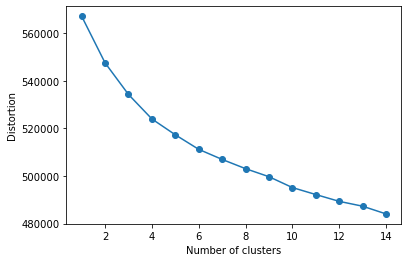

In [35]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(scenarios)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### 2.2.2.1. K-Medoids Clusterings 

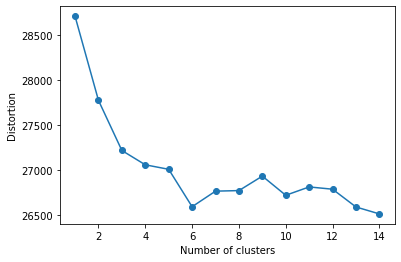

In [11]:
from sklearn_extra.cluster import KMedoids
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state = 0).fit(scenarios)
    distortions.append(kmedoids.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


### 2.2.3. Alternative Strategy using real world data as scenarios

In [12]:
from sklearn_extra.cluster import KMedoids
# Use Real World Data to Reduce Scenario
days = result["date_start"].unique()
days.sort()

NO_RL_SCENARIOS = days.shape[0]

real_scenarios = np.empty(shape=[NO_RL_SCENARIOS, NO_HEXAGONS])

idx = 0
for day in days:
    supply_at_day = result[result["date_start"] == day].sort_values(by=["hex_end_{}".format(HEX_RES)])
    supply_arr = supply_at_day["number_of_low_soc_vehicle"].to_numpy()
    real_scenarios[idx] = supply_arr
    idx += 1

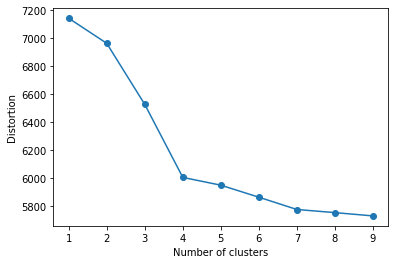

In [13]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 10
distortions = []
for i in range(1, NO_CLUSTER):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state=0).fit(real_scenarios)
    distortions.append(kmedoids.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## 2.3. Scenario Extraction

### 2.3.1. Extraction from Generated Scenarios 

In [14]:
kmedoids = KMedoids(n_clusters= 4, init='k-medoids++', random_state = 0).fit(scenarios)

In [15]:
# Access with index 0-3
kmedoids.cluster_centers_

array([[ 0.,  0.,  0.,  8.,  0.,  4.,  0.,  0.,  0.,  7.,  0.,  0.,  1.,
         6.,  0.,  1., 21., 10.,  4., 11., 19.,  4.,  0.,  3.,  6.,  0.,
         7.,  0.,  2.,  9., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         3.,  9., 11.,  1.,  0.,  3., 18., 15.,  4., 15., 18., 13.,  0.,
         0.,  0., 13., 15.,  5., 20., 11., 17.,  4.,  0.,  0.,  6.,  5.,
         8., 11.,  0.,  0.,  3.,  6.,  1.,  0.,  3.,  0.,  0.,  3.,  0.,
         0., 31., 13., 21.,  3., 22.,  5., 18.,  0.,  5.,  1.,  0.,  0.,
         4.,  1., 27.,  6.,  1., 13.],
       [ 0.,  1.,  0.,  7.,  0.,  5.,  0.,  0.,  0.,  4.,  0.,  1.,  2.,
         4.,  0.,  5., 23.,  6.,  2., 16., 12.,  8.,  0.,  2.,  9.,  0.,
        10.,  1.,  0.,  7., 16.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         4.,  8., 15.,  1.,  3.,  8., 13., 10.,  9., 16., 18., 12.,  0.,
         4.,  0., 12., 18.,  6., 18., 11., 11.,  0.,  0.,  0.,  5.,  1.,
         7., 12.,  0.,  0.,  7.,  7.,  1.,  1.,  2.,  0.,  0.,  2.,  0.,
         1.,

In [16]:
# Assignment of scenarios to clusters
prediction = kmedoids.predict(scenarios)

In [17]:
unique, counts = np.unique(prediction, return_counts=True)
N = sum(counts)
dict(zip(unique, counts/N))

{0: 0.357, 1: 0.332, 2: 0.221, 3: 0.09}

In [35]:
df_multinomial = pd.DataFrame(kmedoids.cluster_centers_, columns=result.hex_end_7.unique())
df_multinomial["probs"] = counts/N
df_multinomial.to_csv("scenarios_multinomial.csv",index=False)

In [36]:
df_multinomial

,871f1d4d0ffffff,871f1d48affffff,871f1d48effffff,871f1d499ffffff,871f18b25ffffff,871f1d4f0ffffff,871f1d4d2ffffff,871f1d49bffffff,871f1d49dffffff,871f1d483ffffff,871f1d4d4ffffff,871f1d488ffffff,871f18b34ffffff,871f1d489ffffff,871f18b0dffffff,871f18b35ffffff,871f18b26ffffff,871f18b2effffff,871f18b21ffffff,871f18b20ffffff,871f1d48bffffff,871f1d4f4ffffff,871f1d48dffffff,871f1d4f6ffffff,871f1d482ffffff,871f18b2cffffff,871f1d4d6ffffff,871f1d4d1ffffff,871f1d4aaffffff,871f1d4d5ffffff,871f1d4abffffff,871f1886bffffff,871f1d4f2ffffff,871f1d486ffffff,871f1d498ffffff,871f1d4a8ffffff,871f1d4a9ffffff,871f18b22ffffff,871f18b30ffffff,871f1d4c2ffffff,871f1d49affffff,871f18b24ffffff,871f18b23ffffff,871f1d4f3ffffff,871f1d48cffffff,871f1d4daffffff,871f1d4d3ffffff,871f1d4b0ffffff,871f1d4deffffff,871f1d485ffffff,871f1d4b2ffffff,871f18b04ffffff,871f1d49cffffff,871f1d49effffff,871f1d4b1ffffff,871f1d4dcffffff,871f1d4aeffffff,871f18869ffffff,871f18b29ffffff,871f1d4f1ffffff,871f18841ffffff,871f1d480ffffff,871f1d481ffffff,871f18b72ffffff,871f18b0bffffff,871f18b31ffffff,871f1d4b3ffffff,871f18b2dffffff,871f1d494ffffff,871f18b36ffffff,871f1d4c6ffffff,871f1d4ddffffff,871f18b05ffffff,871f1d4acffffff,871f18840ffffff,871f18b02ffffff,871f1d4d8ffffff,871f18b06ffffff,871f18b64ffffff,871f1d4b5ffffff,871f1d4a1ffffff,871f1d4a3ffffff,871f1d413ffffff,871f1d41bffffff,871f18b76ffffff,871f1d495ffffff,871f1896bffffff,871f1d491ffffff,871f18b01ffffff,871f1d4adffffff,871f18868ffffff,871f1d4c4ffffff,871f18b11ffffff,871f1d4c0ffffff,871f18b28ffffff,871f18b71ffffff,871f1886affffff,probs
0,2.0,0.0,0.0,17.0,0.0,8.0,0.0,0.0,0.0,10.0,0.0,1.0,6.0,9.0,0.0,11.0,71.0,24.0,4.0,46.0,53.0,11.0,0.0,8.0,18.0,4.0,25.0,3.0,6.0,23.0,33.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,9.0,18.0,38.0,2.0,4.0,26.0,45.0,29.0,23.0,31.0,42.0,40.0,0.0,3.0,0.0,29.0,47.0,17.0,33.0,29.0,33.0,4.0,0.0,0.0,13.0,13.0,15.0,32.0,0.0,0.0,14.0,15.0,0.0,2.0,6.0,0.0,0.0,4.0,0.0,2.0,77.0,39.0,48.0,19.0,62.0,16.0,52.0,0.0,10.0,2.0,2.0,7.0,13.0,5.0,74.0,17.0,7.0,35.0,0.078
1,2.0,0.0,0.0,16.0,0.0,4.0,0.0,0.0,0.0,11.0,0.0,2.0,5.0,5.0,0.0,8.0,64.0,24.0,11.0,45.0,50.0,14.0,0.0,3.0,24.0,4.0,22.0,1.0,1.0,29.0,38.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,13.0,24.0,40.0,5.0,2.0,17.0,42.0,30.0,20.0,47.0,39.0,40.0,0.0,6.0,0.0,22.0,50.0,14.0,45.0,22.0,36.0,2.0,0.0,0.0,18.0,8.0,19.0,37.0,0.0,0.0,12.0,17.0,0.0,4.0,5.0,0.0,0.0,1.0,0.0,2.0,77.0,28.0,51.0,20.0,52.0,15.0,54.0,0.0,14.0,1.0,1.0,5.0,12.0,1.0,67.0,23.0,11.0,40.0,0.366
2,1.0,2.0,0.0,14.0,0.0,11.0,0.0,0.0,0.0,11.0,0.0,0.0,5.0,10.0,0.0,5.0,69.0,25.0,9.0,37.0,48.0,17.0,0.0,10.0,18.0,5.0,18.0,0.0,5.0,18.0,33.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,7.0,16.0,35.0,2.0,5.0,20.0,49.0,35.0,28.0,42.0,43.0,42.0,0.0,8.0,0.0,32.0,47.0,14.0,46.0,28.0,32.0,5.0,0.0,0.0,15.0,19.0,23.0,33.0,0.0,0.0,18.0,15.0,0.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0,76.0,29.0,48.0,17.0,56.0,18.0,51.0,0.0,12.0,1.0,0.0,9.0,8.0,1.0,58.0,17.0,12.0,41.0,0.393
3,0.0,1.0,0.0,21.0,0.0,10.0,0.0,0.0,0.0,11.0,0.0,2.0,6.0,12.0,0.0,6.0,64.0,24.0,11.0,40.0,58.0,15.0,0.0,4.0,24.0,6.0,18.0,0.0,5.0,24.0,26.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,9.0,22.0,35.0,1.0,2.0,26.0,39.0,34.0,20.0,38.0,41.0,36.0,0.0,4.0,0.0,32.0,50.0,16.0,38.0,22.0,46.0,7.0,0.0,0.0,17.0,10.0,22.0,30.0,0.0,0.0,17.0,21.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,78.0,36.0,50.0,24.0,42.0,18.0,51.0,0.0,10.0,2.0,0.0,8.0,12.0,3.0,59.0,15.0,15.0,41.0,0.163


### 2.3.2. Extraction from Real World Data

In [137]:
kmedoids_real_scenario = KMedoids(n_clusters=4, init='k-medoids++', random_state=0).fit(real_scenarios)

In [143]:
# Access with index 0-3
kmedoids_real_scenario.cluster_centers_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [144]:
# Assignment of scenarios to clusters
prediction_real_scenario = kmedoids_real_scenario.predict(real_scenarios)

In [145]:
prediction_real_scenario

array([1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 2,
       1, 3, 3, 1, 2, 1, 2, 1, 3, 3, 1, 1, 2, 2, 2, 3, 3, 1, 1, 1, 2, 1,
       3, 3, 1, 1, 2, 1, 1, 3, 3, 2, 1, 1, 2, 1, 3, 3, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 2, 1, 1, 1, 3, 1, 1, 0, 2, 3, 2, 2,
       2, 2, 2, 1, 3, 1, 1, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 3, 3, 1, 2, 2, 2, 3, 3, 2, 1, 2, 2,
       2, 3, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0])

In [152]:
unique, counts = np.unique(prediction_real_scenario, return_counts=True)
N = sum(counts)
dict(zip(unique, counts/N))

{0: 0.011560693641618497,
 1: 0.3815028901734104,
 2: 0.3236994219653179,
 3: 0.2832369942196532}

# Prices


### Load Price Data

In [39]:
dfAuctionData2019 = pd.read_csv("auction_spot_germany_luxembourg_2019.csv",sep=';',skiprows=1).reset_index()
dfAuctionData2020 = pd.read_csv("auction_spot_germany_luxembourg_2020.csv",sep=';',skiprows=1).reset_index()

dfAuctionData2019["Date"] = pd.to_datetime(dfAuctionData2019["Delivery day"],format="%d.%m.%Y")
dfAuctionData2020["Date"] = pd.to_datetime(dfAuctionData2020["Delivery day"],format="%d.%m.%Y")

dfAuctionData2019.head()

,index,Delivery day,Hour1,Hour2,Hour3A,Hour3B,Hour4,Hour5,Hour6,Hour7,...,Night\n(01-06),Off-Peak 1\n(01-08),Business\n(09-16),Off-Peak\n(01-08 & 21-24),Morning\n(07-10),High Noon\n(11-14),Afternoon\n(15-18),Evening\n(19-24),Sun Peak\n(11-16),Date
0,0,31.12.2019,"24,14","22,12","13,01",NaN,"4,97","9,81","18,37","23,50",...,"15,40","17,89","37,78","25,11","31,92","36,93","41,48","41,99","37,55",2019-12-31
1,1,30.12.2019,"11,07","11,84","6,16",NaN,"1,40","4,81","16,43","26,90",...,"8,62","13,62","30,75","18,61","30,31","29,23","34,62","30,88","30,34",2019-12-30
2,2,29.12.2019,"30,60","28,10","26,92",NaN,"22,85","20,97","21,31","22,72",...,"25,13","24,82","30,67","27,03","26,35","31,04","34,29","34,42","31,31",2019-12-29
3,3,28.12.2019,"30,17","29,50","29,43",NaN,"28,20","28,53","27,40","29,20",...,"28,87","29,26","35,17","31,17","33,07","34,79","37,86","37,83","34,99",2019-12-28
4,4,27.12.2019,"31,17","30,02","28,67",NaN,"28,70","29,19","31,03","33,10",...,"29,80","31,35","40,86","32,99","37,64","40,26","45,81","39,00","41,39",2019-12-27


### Only use Data between 22 and 04

In [40]:
hours = ["22","23","24","1","2","3A","4"]
attributeList = ["Date"]

for h in hours:
    attributeList.append("Hour{}".format(h))

dfAuctionData2019 = dfAuctionData2019[attributeList]
dfAuctionData2020 = dfAuctionData2020[attributeList]
dfAuctionData2019.head()

,Date,Hour22,Hour23,Hour24,Hour1,Hour2,Hour3A,Hour4
0,2019-12-31,"39,74","38,88","37,39","24,14","22,12","13,01","4,97"
1,2019-12-30,"29,67","29,68","24,33","11,07","11,84","6,16","1,40"
2,2019-12-29,"32,00","30,11","25,52","30,60","28,10","26,92","22,85"
3,2019-12-28,"35,39","34,75","30,17","30,17","29,50","29,43","28,20"
4,2019-12-27,"36,67","35,38","33,57","31,17","30,02","28,67","28,70"


### Use same dates as in mobility

In [5]:
resultUnique = result["date_start"].unique()

#Format Date
usedDates = pd.to_datetime(resultUnique,format='%Y%m%d')
dfUsedDates = pd.DataFrame(usedDates,columns=["Date"])

#Join single years
dfUsedDates2019 = dfUsedDates.merge(dfAuctionData2019,on="Date",how="inner")
dfUsedDates2020 = dfUsedDates.merge(dfAuctionData2020,on="Date",how="inner")

#Concat both years
dfUsedDates = pd.concat([dfUsedDates2019,dfUsedDates2020]).reset_index().drop('index',axis=1)
dfUsedDates.head()

NameError: name 'result' is not defined

### Round prices to to cent

In [14]:
columns = list(dfUsedDates.columns)
columns.remove("Date")

dfUsedDates_Rounded = dfUsedDates[["Date"]]
for column in columns:
    dfUsedDates_Rounded[column] = round(dfUsedDates[column].str.replace(",",".").astype(float),0)
    dfUsedDates_Rounded[column] = dfUsedDates_Rounded[column].astype(int)

    dfUsedDates_Rounded[column]
dfUsedDates_Rounded.head()

,Date,Hour22,Hour23,Hour24,Hour1,Hour2,Hour3A,Hour4
0,2019-11-22,39,38,34,35,35,36,36
1,2019-11-24,46,45,40,13,19,13,15
2,2019-11-25,50,46,42,38,36,36,35
3,2019-11-26,44,42,38,39,38,36,36
4,2019-12-18,39,36,32,22,25,26,26


Get Distributions -- Make maybe no sense so do an alternative approach 

In [15]:
#df = pd.DataFrame(dfUsedDates_Rounded["Hour23"].value_counts()).reset_index().sort_values('index')
#df["Hour23"] = df["Hour23"]/df["Hour23"].sum()

## Use real data

## K-Means

In [16]:
from sklearn.cluster import KMeans

In [25]:
dfUsedDates_Rounded_NoDate = dfUsedDates_Rounded[['Hour22','Hour23','Hour24','Hour1','Hour2','Hour3A','Hour4']]

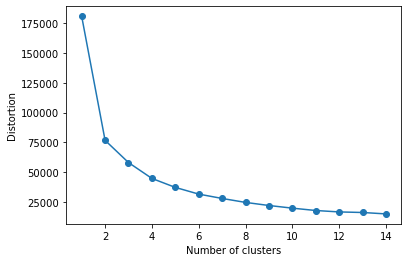

In [26]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(dfUsedDates_Rounded_NoDate)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [28]:
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
km.fit(dfUsedDates_Rounded_NoDate)

KMeans(init='random', n_clusters=2, random_state=0)

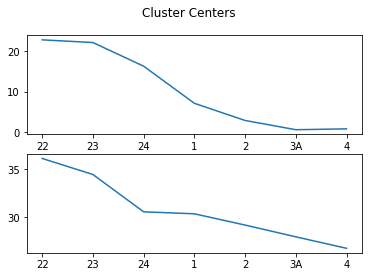

In [29]:
fig, axs = plt.subplots(2)
fig.suptitle('Cluster Centers')
axs[0].plot(hours,km.cluster_centers_[0])
axs[1].plot(hours,km.cluster_centers_[1])

### Probabilities

In [31]:
counts = pd.Series(km.predict(dfUsedDates_Rounded_NoDate)).value_counts()
probabilities = counts/counts.sum()
dfProbabilities = pd.DataFrame(list(zip(list(range(1,len(km.cluster_centers_)+1)),probabilities)),columns=["Scenario","Probability"])
dfProbabilities

,Scenario,Probability
0,1,0.745665
1,2,0.254335


In [32]:
dfPrices = pd.DataFrame(km.cluster_centers_,columns=hours)
dfPrices['Scenario'] =list(range(1,len(km.cluster_centers_)+1))
dfPrices

,22,23,24,1,2,3A,4,Scenario
0,22.727273,22.068182,16.250000,7.113636,2.886364,0.613636,0.818182,1
1,36.155039,34.465116,30.534884,30.325581,29.139535,27.899225,26.689922,2


In [33]:
dfMerge = dfProbabilities.merge(dfPrices,on="Scenario",how="inner")
dfMerge

,Scenario,Probability,22,23,24,1,2,3A,4
0,1,0.745665,22.727273,22.068182,16.250000,7.113636,2.886364,0.613636,0.818182
1,2,0.254335,36.155039,34.465116,30.534884,30.325581,29.139535,27.899225,26.689922


In [34]:
dfMerge.to_csv("priceScenarions1.csv",index=False)

## K-Medoids

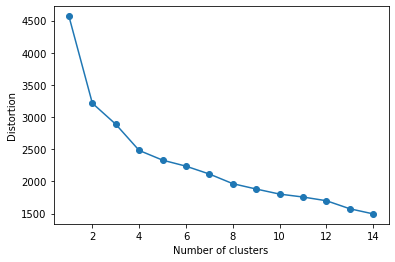

In [35]:
from sklearn_extra.cluster import KMedoids
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state = 0).fit(dfUsedDates_Rounded_NoDate)
    distortions.append(kmedoids.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [36]:
y_km = KMedoids(
    n_clusters=4, init='k-medoids++',random_state=0
)
y_km.fit(dfUsedDates_Rounded_NoDate)

KMedoids(init='k-medoids++', n_clusters=4, random_state=0)

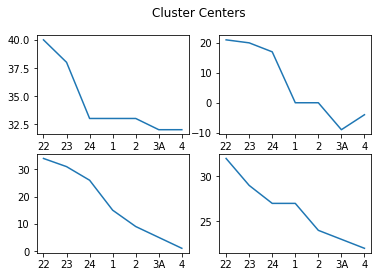

In [37]:
fig, axs = plt.subplots(2,2)
fig.suptitle('Cluster Centers')
axs[0,0].plot(hours,y_km.cluster_centers_[0])
axs[0,1].plot(hours,y_km.cluster_centers_[1])
axs[1,0].plot(hours,y_km.cluster_centers_[2])
axs[1,1].plot(hours,y_km.cluster_centers_[3])

### Probabilities

In [39]:
counts = pd.Series(y_km.predict(dfUsedDates_Rounded_NoDate)).value_counts()
probabilities = counts/counts.sum()
dfProbabilities = pd.DataFrame(list(zip(list(range(1,len(y_km.cluster_centers_)+1)),probabilities)),columns=["Scenario","Probability"])
dfProbabilities

,Scenario,Probability
0,1,0.387283
1,2,0.341040
2,3,0.138728
3,4,0.132948


In [40]:
dfPrices = pd.DataFrame(y_km.cluster_centers_,columns=hours)
dfPrices['Scenario'] =list(range(1,len(y_km.cluster_centers_)+1))
dfPrices

,22,23,24,1,2,3A,4,Scenario
0,40,38,33,33,33,32,32,1
1,21,20,17,0,0,-9,-4,2
2,34,31,26,15,9,5,1,3
3,32,29,27,27,24,23,22,4


In [41]:
dfMerge = dfProbabilities.merge(dfPrices,on="Scenario",how="inner")
dfMerge

,Scenario,Probability,22,23,24,1,2,3A,4
0,1,0.387283,40,38,33,33,33,32,32
1,2,0.341040,21,20,17,0,0,-9,-4
2,3,0.138728,34,31,26,15,9,5,1
3,4,0.132948,32,29,27,27,24,23,22


In [42]:
dfMerge.to_csv("priceScenarions2.csv",index=False)

## Consider whole Year (2019)

In [41]:
# curtail df and rename column Hour3A
dfAuctionData2019 = dfAuctionData2019.drop(columns=["Date"], errors="ignore")
dfAuctionData2019.rename(columns={"Hour3A":"Hour3"}, inplace=True)

# convert to floats
for col in dfAuctionData2019.columns:
    dfAuctionData2019[col] = pd.to_numeric(dfAuctionData2019[col].str.replace(",","."))
    
dfAuctionData2019.dropna(inplace=True)

#### k-Medoids

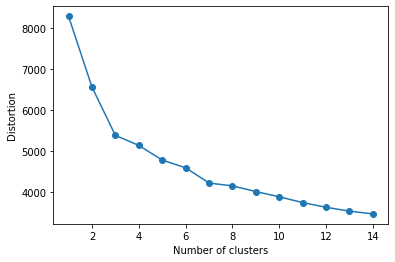

In [42]:
# calculate distortion for a range of number of cluster
from sklearn_extra.cluster import KMedoids
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state = 0).fit(dfAuctionData2019)
    distortions.append(kmedoids.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [43]:
y_km = KMedoids(n_clusters=4, init='k-medoids++',random_state=0)
y_km.fit(dfAuctionData2019)

KMedoids(init='k-medoids++', max_iter=300, metric='euclidean', n_clusters=4,
         random_state=0)

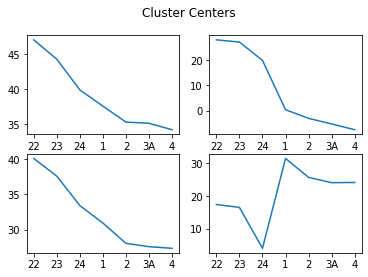

In [44]:
fig, axs = plt.subplots(2,2)
fig.suptitle('Cluster Centers')
axs[0,0].plot(hours,y_km.cluster_centers_[0])
axs[0,1].plot(hours,y_km.cluster_centers_[1])
axs[1,0].plot(hours,y_km.cluster_centers_[2])
axs[1,1].plot(hours,y_km.cluster_centers_[3])

In [46]:
counts = pd.Series(y_km.predict(dfAuctionData2019)).value_counts()
probabilities = counts/counts.sum()
dfProbabilities = pd.DataFrame(list(zip(list(range(1,len(y_km.cluster_centers_)+1)),probabilities)),columns=["Scenario","Probability"])
dfProbabilities

,Scenario,Probability
0,1,0.489011
1,2,0.387363
2,3,0.085165
3,4,0.038462


In [47]:
dfPrices = pd.DataFrame(y_km.cluster_centers_,columns=hours)
dfPrices['Scenario'] =list(range(1,len(y_km.cluster_centers_)+1))
dfPrices

,22,23,24,1,2,3A,4,Scenario
0,47.00,44.25,39.88,37.57,35.30,35.13,34.22,1
1,27.87,27.01,19.80,0.40,-2.99,-5.19,-7.45,2
2,40.07,37.57,33.41,30.94,28.07,27.60,27.37,3
3,17.39,16.51,4.02,31.44,25.66,24.05,24.11,4


In [48]:
dfMerge = dfProbabilities.merge(dfPrices,on="Scenario",how="inner")
dfMerge

,Scenario,Probability,22,23,24,1,2,3A,4
0,1,0.489011,47.00,44.25,39.88,37.57,35.30,35.13,34.22
1,2,0.387363,27.87,27.01,19.80,0.40,-2.99,-5.19,-7.45
2,3,0.085165,40.07,37.57,33.41,30.94,28.07,27.60,27.37
3,4,0.038462,17.39,16.51,4.02,31.44,25.66,24.05,24.11


In [49]:
dfMerge.to_csv("priceScenarions3.csv",index=False)